# Polynomial regression 

The example belows uses a temperature-energy dataset in order to illustrate how to perform a non linear regression.

Workflow:
1. Preparation
    - Extract the dataset from the _power_demand_vs_temperature.csv_ 
    - Explore the dataset and check for missing values
    - Plot the distribution
    - Divide the dataset into train and test 
    - Create an evaluation function
2. First experiment
    - Create a linear model 
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
3. Second experiment
    - Create a polynomial regression model with degree 2
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
4. Third experiment
    - repeat the steps done in the second experiment but with degree 3
5. Third experiment
    - repeat the steps done in the second experiment but with degree 4
6. Compare the evaluation of each model


In [53]:
# Code source: Filippo Orazi
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8")

random_state = 42  # this will be used to guarantee the repeatability of the experiment

## Dataset preparation

### Load the dataset from a `.csv` file
This cell allows full compatibility between execution in Google Colab and in local


In [54]:
try:
    import google.colab.files

    IN_COLAB = True
except:
    IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()

The file must be available in the same directory, or uploaded in the Colab environment in the execution of the previous cell


Set the date column as index

In [55]:
import pandas as pd

df = pd.read_csv("power_demand_vs_temperature.csv")
df.head()

,date,demand,temp
0,2015-01-01,1.736065,1.7
1,2015-01-02,1.831672,2.2
2,2015-01-03,1.714934,14.4
3,2015-01-04,1.628577,15.6
4,2015-01-05,2.045394,0.0


### Explore the dataset and check for missing values


In [56]:
df.describe()

,demand,temp
count,1096.000000,1096.000000
mean,1.831796,16.927737
std,0.329434,10.791581
min,1.316033,-15.000000
25%,1.581654,8.900000
50%,1.731479,18.900000
75%,2.024869,26.100000
max,2.804025,33.900000


In [57]:
df.shape[0] - df.dropna().shape[0]

0

### Create X and y 

In [58]:
X = df.iloc[:, [2]]
y = df.iloc[:, [1]]

X.head()

,temp
0,1.7
1,2.2
2,14.4
3,15.6
4,0.0


In [59]:
y.head()

,demand
0,1.736065
1,1.831672
2,1.714934
3,1.628577
4,2.045394


### Plot the distribution



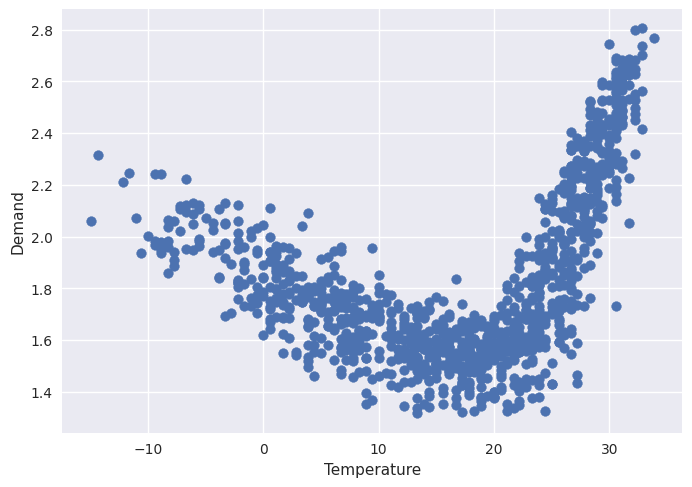

In [60]:
import matplotlib.pyplot as plt

plt.scatter(X.temp, y.demand)
plt.xlabel("Temperature")
plt.ylabel(ylabel="Demand")
plt.show()

### Divide the dataset in train and test splits

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=random_state
)

print("X:\t", X.shape)
print("X_train:", X_train.shape)
print("X_test:\t", X_test.shape)
print("y:\t", y.shape)
print("y_train:", y_train.shape)
print("y_test:\t", y_test.shape)

X:	 (1096, 1)
X_train: (767, 1)
X_test:	 (329, 1)
y:	 (1096, 1)
y_train: (767, 1)
y_test:	 (329, 1)


### Create an evaluation function to compute, print and return the metrics: rmse r2 f-statistic and p-value

In [62]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def f_test(y_true, y_pred, n_var, n_obs, sn=.95):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var+1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE 
    MST = SST / DFT
    F = MSM / MSE
    # f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    p = 1-scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic 
    return F, p

def print_eval(X, y, model):
    pred = model.predict(X)
    F, p = f_test(y, pred, X.shape[1], X.shape[0])
    print(" Mean squared error: \t{:.5}".format(mean_squared_error(y,pred)))
    print(" r2 score: \t\t{:.5}".format(r2_score(y,pred)))
    print(" f-statistic: \t\t{:.5}".format(F))
    print(" p-value: \t\t{:.5}".format(p))
    return mean_squared_error(pred, y), r2_score(pred, y), F, p


## First experiment
Create a linear model 

Train the model on X_train and y_train 

Evaluate the model on X_test and y_test


In [63]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_linear = regr.predict(X_test)
evalFunc(y_pred_linear)

Mean Square Error: 0.10165083485105061
R-square: 0.16809034828105496


#### Visualize the prediction of the model 

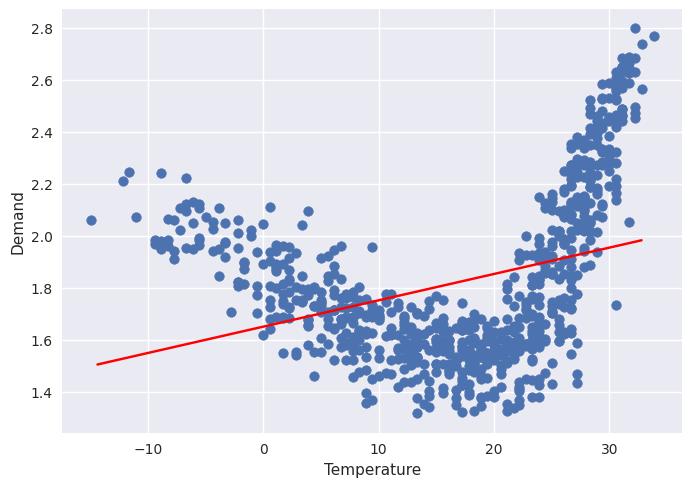

In [75]:
df2 = X_test[["temp"]].assign(demand=y_pred_linear).sort_values("temp")

plt.scatter(X_train.temp, y_train)
plt.plot(df2.temp, df2.demand, color="red")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

## Second experiment - Polynomial regression
We can clearly see that the linear regression model cannot really approximate the data distribution.

We can now try with a non linear regression model:
1. Use the sklearn fucntion _PolynomialFeature_ to create a new array of features. Set _degree=2_ and _include_bias=False_
2. Train a Linear regression model with the new features
3. Evaluate the model 
4. Visualize the predicted values of the model

#### Polynomial degree = 2

In [65]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_train = poly.fit_transform(X_train)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_test = poly.fit_transform(X_test)


poly_reg = LinearRegression()
poly_reg.fit(poly_features_train, y_train)
y_pred_pol2 = poly_reg.predict(poly_features_test)

In [66]:
evalFunc(y_pred_pol2)

Mean Square Error: 0.033456250068637464
R-square: 0.7261943063900527


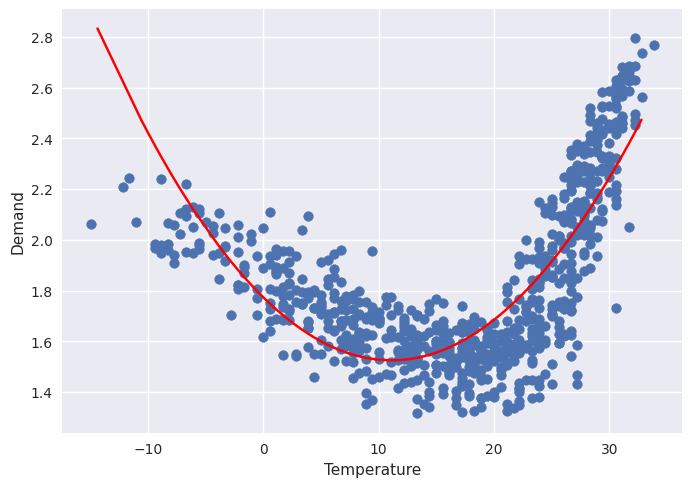

In [67]:
df2 = X_test[["temp"]].assign(demand=y_pred_pol2).sort_values("temp")

plt.scatter(X_train.temp, y_train)
plt.plot(df2.temp, df2.demand, color="red")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

## Third experiment

#### Polynomial degree = 3

In [68]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features_train = poly.fit_transform(X_train)
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features_test = poly.fit_transform(X_test)


poly_reg = LinearRegression()
poly_reg.fit(poly_features_train, y_train)
y_pred_pol3 = poly_reg.predict(poly_features_test)

In [69]:
evalFunc(y_pred_pol3)

Mean Square Error: 0.021749417017788347
R-square: 0.8220029381670013


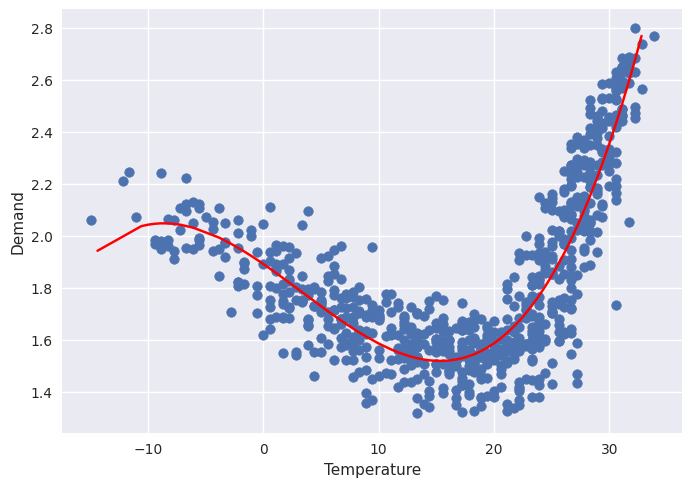

In [70]:
df2 = X_test[["temp"]].assign(demand=y_pred_pol3).sort_values("temp")

plt.scatter(X_train.temp, y_train)
plt.plot(df2.temp, df2.demand, color="red")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

## Fourth experiment
### Polynomial degree = 4

In [71]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features_train = poly.fit_transform(X_train)
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features_test = poly.fit_transform(X_test)


poly_reg = LinearRegression()
poly_reg.fit(poly_features_train, y_train)
y_pred_pol4 = poly_reg.predict(poly_features_test)

In [72]:
evalFunc(y_pred_pol4)

Mean Square Error: 0.021749417017788347
R-square: 0.8220029381670013


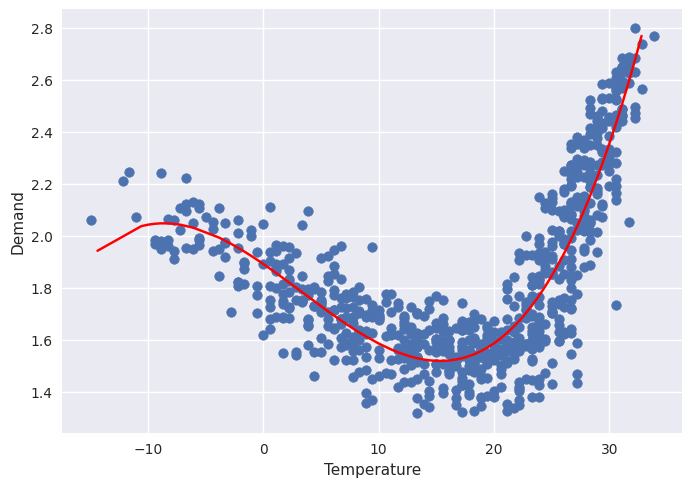

In [73]:
df2 = X_test[["temp"]].assign(demand=y_pred_pol4).sort_values("temp")

plt.scatter(X_train.temp, y_train)
plt.plot(df2.temp, df2.demand, color="red")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

## Compare the performance of the four models

In [74]:
comparison = pd.DataFrame()
comparison["linear"] = [1, 2, 3]
comparison["polynomial d = 2"] = [1, 2, 3]
comparison["polynomial d = 3"] = [1, 2, 3]
comparison["polynomial d = 4"] = [1, 2, 3]

display(comparison)

,linear,polynomial d = 2,polynomial d = 3,polynomial d = 4
0,1,1,1,1
1,2,2,2,2
2,3,3,3,3
